<a href="https://colab.research.google.com/github/shreesowndarya/HRC/blob/main/HRC_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HRC Tutorial on nfp and GNNs

11th August 2022

Shree Sowndarya S V

This collab can be run remoting using google's computing resources as well as on local machines. Most of the comments would remain the same aside for enviroment setup i.e., the installation of software blocks.

# Necessary packages to install for this code to run

*   Step 1: PIP installation of necessary packages


In [1]:
%%time
#install nfp
!pip install nfp rdkit-pypi > logpip.txt

CPU times: user 66.3 ms, sys: 14.4 ms, total: 80.7 ms
Wall time: 11.1 s


# Necessary datasets we would be working with 

*   Step 1: Loading the dataset from github
*   Step 2: Split the data for train and test


In [4]:
# Step 1: Loading the dataset from github
import pandas as pd
url = 'https://raw.githubusercontent.com/shreesowndarya/HRC/main/reduced_radical_db_redox_potentials.csv'
data = pd.read_csv(url)
data.head()

,smiles,oxidation,reduction
0,C[C](CO)CCC#N,0.027999,-1.660134
1,CC1=CC[C](O)CC1,-0.770340,-1.920379
2,C=CCCC[CH]CCN,0.231808,-1.867590
3,C[C](C)NCCCN,-1.777168,-2.273575
4,[CH2]O/C=C/C(=O)OC,0.374692,-1.128816


In [5]:
# Step 2: Split the data for train and test
import numpy as np
valid, test, train = np.split(data.smiles.sample(frac=1., random_state=1), [100, 200])
print('Training Set:', len(train))
print('Validation Set:' , len(valid))
print('Testing Set:' , len(test))

Training Set: 2097
Validation Set: 100
Testing Set: 100


# nfp example

*   Step 1: Import nfp for processing smiles to graphs
*   Step 2: Define the kind of features we are using for atoms and bonds in the molecule
*   Step 3: Example showing the features utilized for atoms and bonds
*   Step 4: create a nfp graph processor using the feature we need
*   Step 5: Example of graphical inputs for SMILES - 'CCO'
*   Step 6: Graphical inputs for a dataset of SMILES- What do the numbers mean?

In [6]:
# Step 1:
from nfp.preprocessing.mol_preprocessor import SmilesPreprocessor
from nfp.preprocessing.features import get_ring_size

In [7]:
# Step 2: Definition the kind of features we are using for atoms and bonds in the molecule
def atom_featurizer(atom):
    """ Return a string representing the atom type 
    
    returns [symbol, is_aromatic, ring_size, degree, total_num_Hs]
    """

    return str((
        atom.GetSymbol(),
        atom.GetIsAromatic(),
        get_ring_size(atom, max_size=6),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    ))

def bond_featurizer(bond, flipped=False):
    """ Get a similar classification of the bond type.
    Flipped indicates which 'direction' the bond edge is pointing.

    returns [atoms_in_bond, bond_type, ring_size]
    """
    
    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))
    
    btype = str(bond.GetBondType())
    ring = 'R{}'.format(get_ring_size(bond, max_size=6)) if bond.IsInRing() else ''
    
    return " ".join([atoms, btype, ring]).strip()

In [8]:
# Step 3: Example showing the features utilized for atoms and bonds
from rdkit import Chem

smiles = 'CCO'
mol = Chem.MolFromSmiles(smiles)
print('Atom features:', atom_featurizer(mol.GetAtoms()[0]))
print('Bond features:', bond_featurizer(mol.GetBonds()[1]))

Atom features: ('C', False, 0, 1, 3)
Bond features: C-O SINGLE


In [9]:
# Step 4: create a nfp graph processor using the feature we need
preprocessor = SmilesPreprocessor(atom_features=atom_featurizer, bond_features=bond_featurizer, explicit_hs=False)

In [10]:
# Step 5: Example of graphical inputs for SMILES - 'CCO'
print('Atoms Classes:', preprocessor(smiles, train=True)['atom']) # Atom types, as integer classes
print('Bond Classes:', preprocessor(smiles, train=True)['bond']) # Bond types, as integer classes
print('Connectivity:', preprocessor(smiles, train=True)['connectivity']) # A connectivity array, where row i indicates bond i connects atom j to atom k

Atoms Classes: [2 3 4]
Bond Classes: [2 2 3 4]
Connectivity: [[0 1]
 [1 0]
 [1 2]
 [2 1]]


In [11]:
# Step 6: Graphical inputs for a dataset of SMILES - What do the numbers mean?
for smiles in data.smiles: 
  preprocessor(smiles, train=True)

print('Atom data types: \n', pd.Series(preprocessor.atom_tokenizer._data))
print('\nBond data types: \n', pd.Series(preprocessor.bond_tokenizer._data))

Atom data types: 
 unk                           1
('C', False, 0, 1, 3)         2
('C', False, 0, 2, 2)         3
('O', False, 0, 1, 1)         4
('C', False, 0, 3, 0)         5
                             ..
('S', False, 'max', 3, 0)    88
('S', False, 3, 2, 0)        89
('S', False, 4, 2, 0)        90
('C', True, 3, 3, 0)         91
('N', False, 3, 4, 0)        92
Length: 92, dtype: int64

Bond data types: 
 unk                  1
C-C SINGLE           2
C-O SINGLE           3
O-C SINGLE           4
C-N TRIPLE           5
                  ... 
O-S SINGLE R5      116
S-O SINGLE R5      117
N-N DOUBLE R3      118
C-C TRIPLE Rmax    119
C-C AROMATIC R3    120
Length: 120, dtype: int64


# Building Graph Neural Networks (GNNs)

*   Step 1: Convert the graphs into tensorflow syntax for builing GNN - Here we are considering only Oxidation to keep things simple
*   Step 2: Define the neural network model 
*   Step 3: Compile and construct the GNNs

In [12]:
# Step 1: Convert the graphs into tensorflow syntax for builing GNN
import tensorflow as tf

train_dataset = tf.data.Dataset.from_generator(
    lambda: ((preprocessor(row.smiles, train=True), row['oxidation'])
            for i, row in data[data.smiles.isin(train)].iterrows()),
    output_signature=(preprocessor.output_signature, tf.TensorSpec((), dtype=tf.float32)))\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=(128))\
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: ((preprocessor(row.smiles, train=False), row['oxidation'])
            for i, row in data[data.smiles.isin(valid)].iterrows()),
    output_signature=(preprocessor.output_signature, tf.TensorSpec((), dtype=tf.float32)))\
    .cache()\
    .padded_batch(batch_size=(64))\
    .prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
  lambda: (preprocessor(smiles, train=False)
          for smiles in test),
  output_signature=preprocessor.output_signature)\
  .padded_batch(batch_size=len(test))\
  .prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
# Step 2: Define the neural network model
from tensorflow.keras import layers
import nfp

# Input layers
atom = layers.Input(shape=[None], dtype=tf.int64, name='atom')
bond = layers.Input(shape=[None], dtype=tf.int64, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int64, name='connectivity')

num_features = 8  # Controls the size of the model

# Convert from a single integer defining the atom state to a vector
# of weights associated with that class
atom_state = layers.Embedding(preprocessor.atom_classes, num_features,
                              name='atom_embedding', mask_zero=True)(atom)

# Ditto with the bond state
bond_state = layers.Embedding(preprocessor.bond_classes, num_features,
                              name='bond_embedding', mask_zero=True)(bond)

# Here we use our first nfp layer. This is an attention layer that looks at
# the atom and bond states and reduces them to a single, graph-level vector. 
# mum_heads * units has to be the same dimension as the atom / bond dimension
global_state = nfp.GlobalUpdate(units=8, num_heads=1)([atom_state, bond_state, connectivity])

for _ in range(3):  # Do the message passing
    new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity, global_state])
    bond_state = layers.Add()([bond_state, new_bond_state])
    
    new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity, global_state])
    atom_state = layers.Add()([atom_state, new_atom_state])
    
    new_global_state = nfp.GlobalUpdate(units=8, num_heads=1)(
        [atom_state, bond_state, connectivity, global_state]) 
    global_state = layers.Add()([global_state, new_global_state])

# Since the final prediction is a single, molecule-level property (oxidation, reduction), we 
# reduce the last global state to a single prediction
ox_prediction = layers.Dense(1)(global_state)

# Construct the tf.keras model
model = tf.keras.Model([atom, bond, connectivity], [ox_prediction])

In [14]:
# Step 3: Compile and construct the GNNs
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(1E-3))
model.fit(train_dataset, validation_data=valid_dataset, epochs=100)

Epoch 1/100
17/17 [==============================] - 21s 518ms/step - loss: 0.6791 - val_loss: 0.6601
Epoch 2/100
17/17 [==============================] - 0s 15ms/step - loss: 0.5657 - val_loss: 0.5792
Epoch 3/100
17/17 [==============================] - 0s 16ms/step - loss: 0.5163 - val_loss: 0.5426
Epoch 4/100
17/17 [==============================] - 0s 15ms/step - loss: 0.4912 - val_loss: 0.5394
Epoch 5/100
17/17 [==============================] - 0s 16ms/step - loss: 0.4775 - val_loss: 0.4963
Epoch 6/100
17/17 [==============================] - 0s 16ms/step - loss: 0.4612 - val_loss: 0.4696
Epoch 7/100
17/17 [==============================] - 0s 15ms/step - loss: 0.4369 - val_loss: 0.4771
Epoch 8/100
17/17 [==============================] - 0s 14ms/step - loss: 0.4393 - val_loss: 0.4644
Epoch 9/100
17/17 [==============================] - 0s 14ms/step - loss: 0.4101 - val_loss: 0.4406
Epoch 10/100
17/17 [==============================] - 0s 15ms/step - loss: 0.3944 - val_loss: 0.45

Testing Graph Neural Networks (GNNs)

*   Step 1: Predict using the built model
*   Step 2: Plot to see test set





In [15]:
# Step 1: Predict using the built model
test_predictions = model.predict(test_dataset)
test_db_values = data.set_index('smiles').reindex(test)['oxidation'].values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(1.5, -1.5, '$R^2$ = 0.8 \nMAE = 0.2 ')

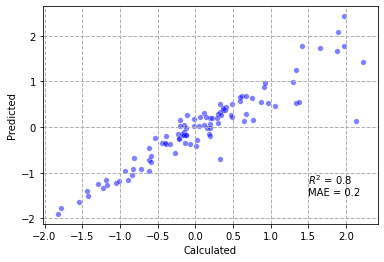

In [19]:
# Step 2: Plot to see test set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

fig = plt.subplots()

ax1 = sns.scatterplot(test_db_values,test_predictions.flatten(),s=30,marker='o',color='b',alpha=0.5)
ax1.set_xlabel(r'Calculated',fontsize=10)
ax1.set_ylabel(r'Predicted',fontsize=10)
ax1.grid(linestyle='--', linewidth=1)

mae = metrics.mean_absolute_error(test_db_values,test_predictions.flatten())
r2 = metrics.r2_score(test_db_values,test_predictions.flatten())

plt.annotate(f"$R^2$ = {round(r2,1)} \nMAE = {round(mae,1)} ", xy=(1.5, -1.5), fontsize=10)